In [ ]:
%pip install sumy rouge-score nltk lxml_html_clean spacy matplotlib scikit-learn pandas 

In [2]:
# Imports and global variables

from sumy.parsers.plaintext import PlaintextParser
from sumy.parsers.html import HtmlParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.text_rank import TextRankSummarizer
from sumy.summarizers.lsa import LsaSummarizer
from sumy.summarizers.lex_rank import LexRankSummarizer
from sumy.summarizers.edmundson import EdmundsonSummarizer
from sumy.nlp.stemmers import Stemmer
from sumy.utils import get_stop_words
import spacy
from rouge_score import rouge_scorer
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# python -m spacy download en_core_web_sm <-- Run this command in terminal if the model is not already downloaded
nlp = spacy.load("en_core_web_sm")

# Initialize language for stemmer and the number of most important sentences returned
LANGUAGE = "english"
SENTENCES_COUNT = 3

# **IMPORTANT Note**: Since we are using Sumy package instead of the original PyTLDR, there is no direct counterpart for Relevance sentence scoring. We use the closest equivalent LexRank which also uses cosine similarity.

### Task 1: Three summarization algorithms


In [3]:
# Example text document
example_document = """
Natural language processing and text mining is a course in Master's degree program in the Univeristy of Oulu.
Video games are good for passing time efficiently.
University of Oulu has multiple restaurants which are cheap and offer healthy food.
Multiple different courses require experience on programming languages.
Oulu is known for many technology companies such as Oura and Fingersoft.
"""
parser = PlaintextParser.from_string(example_document, Tokenizer(LANGUAGE))

print("--- Top 3 Most Important Sentences by Each Algorithm (Stemming and Stopword Removal) ---")
# TextRank summarization
textrank_summarizer = TextRankSummarizer(Stemmer(LANGUAGE))
textrank_summarizer.stop_words = get_stop_words(LANGUAGE)
print("\nTextRank Summary:")
for sentence in textrank_summarizer(parser.document, SENTENCES_COUNT):
    print("-", sentence)

# LSA summarization
lsa_summarizer = LsaSummarizer(Stemmer(LANGUAGE))
lsa_summarizer.stop_words = get_stop_words(LANGUAGE)
print("\nLSA Summary:")
for sentence in lsa_summarizer(parser.document, SENTENCES_COUNT):
    print("-", sentence)

# LexRank summarization
lexrank_summarizer = LexRankSummarizer(Stemmer(LANGUAGE))
lexrank_summarizer.stop_words = get_stop_words(LANGUAGE)
print("\nLexRank Summary:")
for sentence in lexrank_summarizer(parser.document, SENTENCES_COUNT):
    print("-", sentence)

print("\n--- Top 3 Most Important Sentences by Each Algorithm (NO Stemming and Stopword Revomal) ---")
# TextRank summarization
textrank_summarizer = TextRankSummarizer()
print("\nTextRank Summary:")
for sentence in textrank_summarizer(parser.document, SENTENCES_COUNT):
    print("-", sentence)

# LSA summarization
lsa_summarizer = LsaSummarizer()
print("\nLSA Summary:")
for sentence in lsa_summarizer(parser.document, SENTENCES_COUNT):
    print("-", sentence)

# LexRank summarization
lexrank_summarizer = LexRankSummarizer()
print("\nLexRank Summary:")
for sentence in lexrank_summarizer(parser.document, SENTENCES_COUNT):
    print("-", sentence)

--- Top 3 Most Important Sentences by Each Algorithm (Stemming and Stopword Removal) ---

TextRank Summary:
- Natural language processing and text mining is a course in Master's degree program in the Univeristy of Oulu.
- Video games are good for passing time efficiently.
- University of Oulu has multiple restaurants which are cheap and offer healthy food.

LSA Summary:
- Natural language processing and text mining is a course in Master's degree program in the Univeristy of Oulu.
- University of Oulu has multiple restaurants which are cheap and offer healthy food.
- Multiple different courses require experience on programming languages.

LexRank Summary:
- Natural language processing and text mining is a course in Master's degree program in the Univeristy of Oulu.
- Video games are good for passing time efficiently.
- University of Oulu has multiple restaurants which are cheap and offer healthy food.

--- Top 3 Most Important Sentences by Each Algorithm (NO Stemming and Stopword Revoma

### Task 2: Text summarizer GUI


In [4]:
# The summarizer GUI will open in a new window and this cell will run as long as the window is open.

import tkinter as tk
from tkinter import filedialog, scrolledtext, messagebox


# Helper function for text summarization
def summarize_text(source, is_url=False):
    try:
        if is_url:
            parser = HtmlParser.from_url(source, Tokenizer(LANGUAGE))
        else:
            parser = PlaintextParser.from_file(source, Tokenizer(LANGUAGE))

        # Initialize summarizers, use stemming and stop word removal
        textrank = TextRankSummarizer(Stemmer(LANGUAGE))
        textrank.stop_words = get_stop_words(LANGUAGE)
        lsa = LsaSummarizer(Stemmer(LANGUAGE))
        lsa.stop_words = get_stop_words(LANGUAGE)
        lexrank = LexRankSummarizer(Stemmer(LANGUAGE))
        lexrank.stop_words = get_stop_words(LANGUAGE)

        # Create dictionary for summarizer outputs
        summaries = {
            "TextRank": "\n\n ".join(
                f" - {s}" for s in textrank(parser.document, SENTENCES_COUNT)
            ),
            "LSA": "\n\n".join(f" - {s}" for s in lsa(parser.document, SENTENCES_COUNT)),
            "LexRank": "\n\n".join(
                f" - {s}" for s in lexrank(parser.document, SENTENCES_COUNT)
            ),
        }

        return summaries

    except Exception as e:
        messagebox.showwarning("Input Error", "Please enter a URL or choose a file")
        print("Error: ", e)
        return None


# Helper function for browsing a file
def browse_file():
    filename = filedialog.askopenfilename(filetypes=[("Text files", "*.txt")])
    entry_source.delete(0, tk.END)
    entry_source.insert(0, filename)


# Helper function for running summary
def run_summary():
    source = entry_source.get().strip()
    if not source:
        messagebox.showwarning("Input Error", "Please enter a URL or choose a file")
        return None

    is_url = source.startswith("http")
    summaries = summarize_text(source, is_url)

    # Delete old summaries and add new ones (if summarizers are run multiple times)
    if summaries:
        text_textrank.delete(1.0, tk.END)
        text_lsa.delete(1.0, tk.END)
        text_lexrank.delete(1.0, tk.END)
        text_textrank.insert(tk.END, summaries["TextRank"])
        text_lsa.insert(tk.END, summaries["LSA"])
        text_lexrank.insert(tk.END, summaries["LexRank"])


# GUI setup using tkinter library
root = tk.Tk()
root.title("Text Summarizer")
root.geometry("1200x700")

frame_top = tk.Frame(root)
frame_top.pack(pady=10)

tk.Label(
    frame_top, text="Enter URL or choose a file to get 3 most important sentences:"
).pack(anchor="w", padx=5)
entry_source = tk.Entry(frame_top, width=70)
entry_source.pack(side=tk.LEFT, padx=5)

btn_browse = tk.Button(frame_top, text="Browse File", command=browse_file)
btn_browse.pack(side=tk.LEFT, padx=5)

btn_summarize = tk.Button(frame_top, text="Summarize", command=run_summary)
btn_summarize.pack(side=tk.LEFT, padx=5)

# --Text areas for summaries--
frame_texts = tk.Frame(root)
frame_texts.pack(fill=tk.BOTH, expand=True)

# TextRank section
frame_textrank = tk.Frame(frame_texts)
frame_textrank.pack(side=tk.LEFT, fill=tk.BOTH, expand=True, padx=5)

tk.Label(frame_textrank, text="TextRank Summary:").pack(anchor="n", pady=5)
text_textrank = scrolledtext.ScrolledText(frame_textrank, wrap=tk.WORD, width=40)
text_textrank.pack(fill=tk.BOTH, expand=True)

# LSA section
frame_lsa = tk.Frame(frame_texts)
frame_lsa.pack(side=tk.LEFT, fill=tk.BOTH, expand=True, padx=5)

tk.Label(frame_lsa, text="LSA Summary:").pack(pady=5)
text_lsa = scrolledtext.ScrolledText(frame_lsa, wrap=tk.WORD, width=40)
text_lsa.pack(fill=tk.BOTH, expand=True)

# LexRank section
frame_lexrank = tk.Frame(frame_texts)
frame_lexrank.pack(side=tk.LEFT, fill=tk.BOTH, expand=True, padx=5)

tk.Label(frame_lexrank, text="LexRank Summary:").pack(pady=5)
text_lexrank = scrolledtext.ScrolledText(frame_lexrank, wrap=tk.WORD, width=40)
text_lexrank.pack(fill=tk.BOTH, expand=True)

print("Text Summarizer GUI is running on a separate window!")
root.mainloop()

Text Summarizer GUI is running on a separate window!


### Task 3: Summarizer Performance on CNN/Dailymail Dataset


Total extracted samples: 89
Total extracted words in documents: 61700
rouge2 fmeasure top score for TextRank: 0.187
rouge2 fmeasure top score for LSA: 0.204
rouge2 fmeasure top score for LexRank: 0.182
rouge3 fmeasure top score for TextRank: 0.113
rouge3 fmeasure top score for LSA: 0.132
rouge3 fmeasure top score for LexRank: 0.114


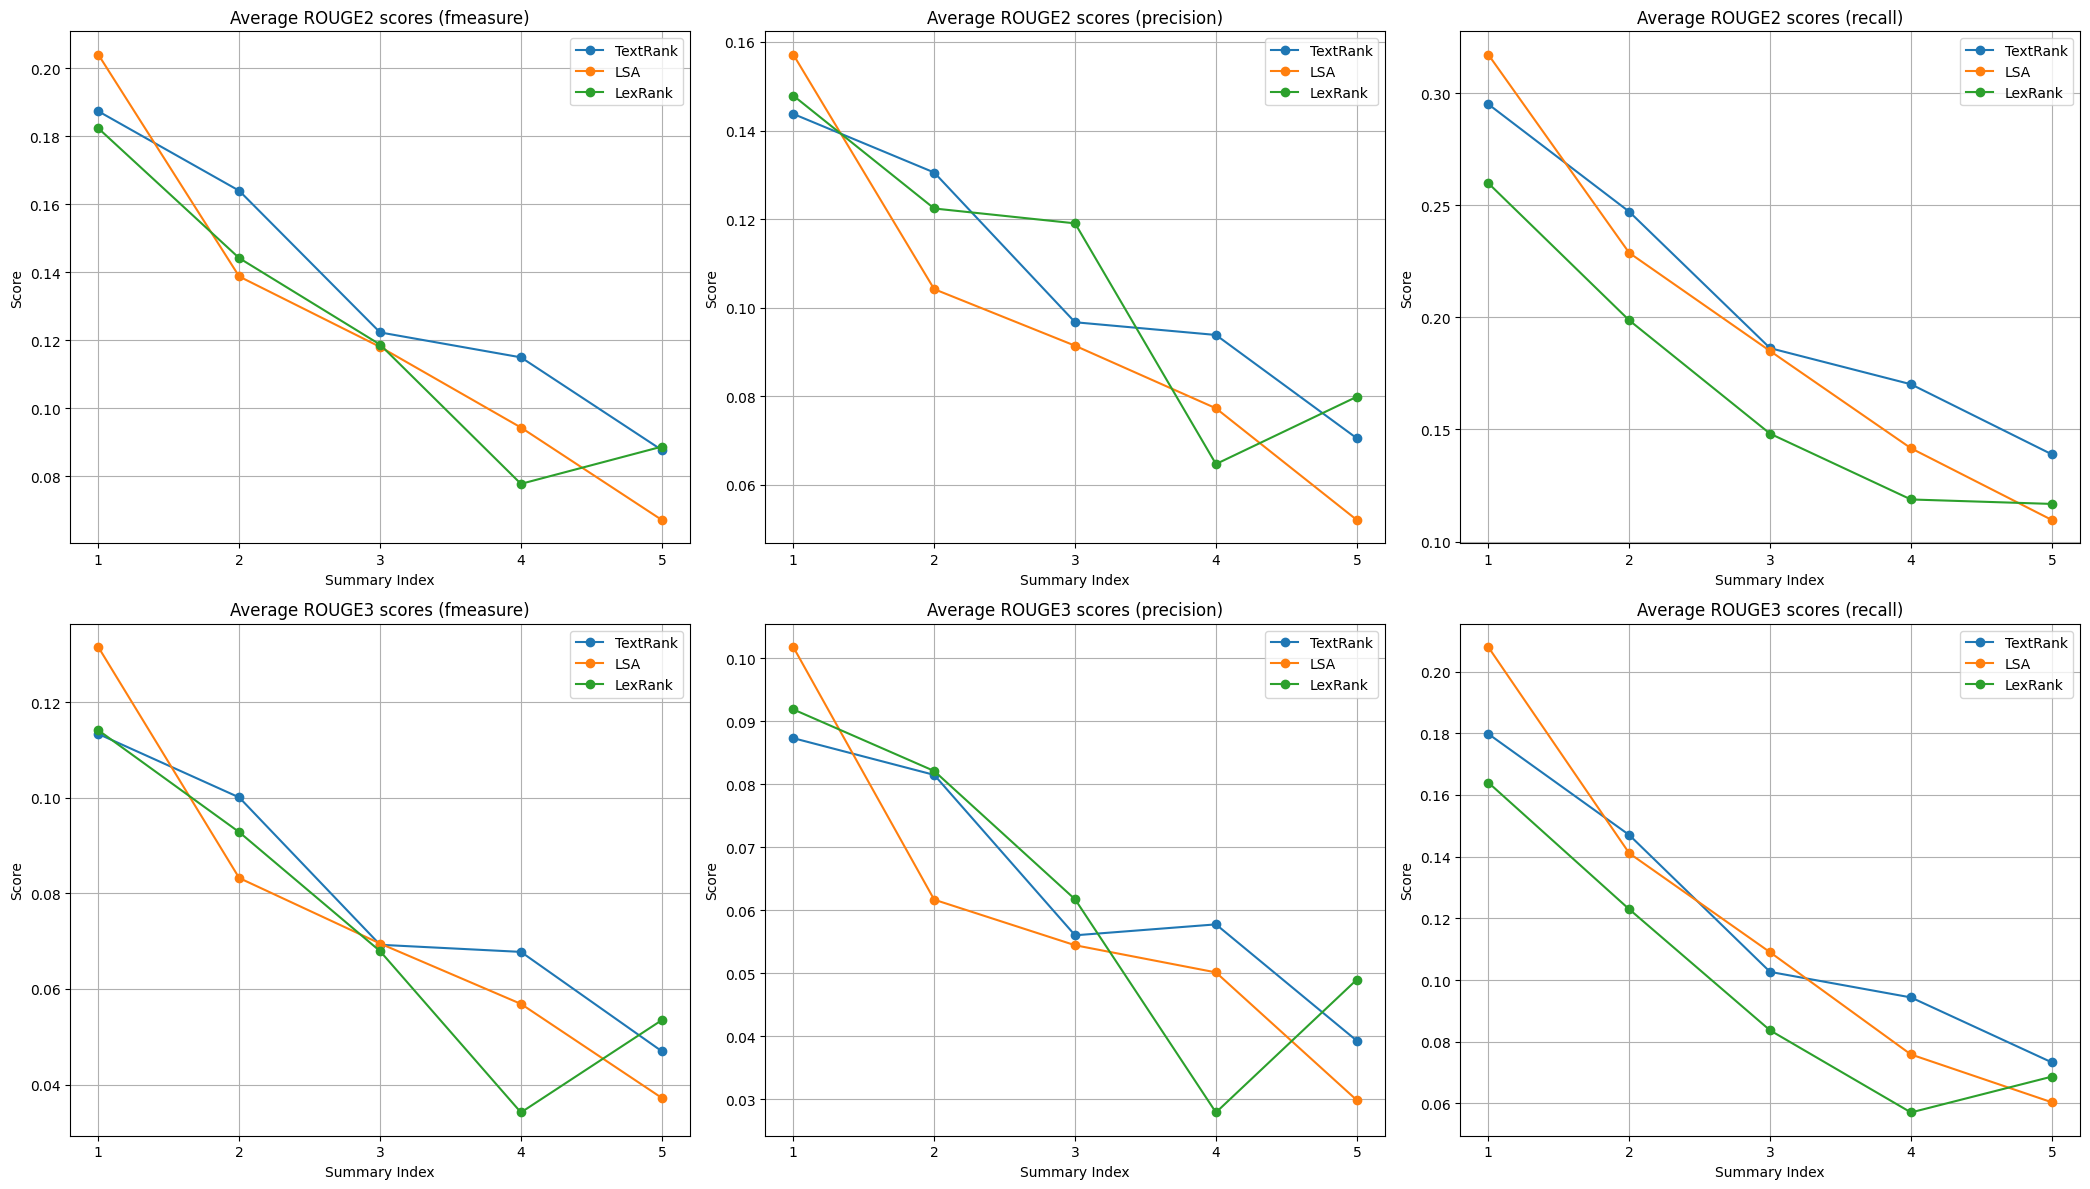

In [5]:
import json

STEM = True
STOP_WORD_REMOVAL = True
TOP_SUMMARIES_COUNT = 5


def extract_doc_and_abstraction(data):
    extracted_data = []
    data_idx = -1
    extracted_word_count = 0
    for idx, line in enumerate(data):
        if line == "Document\n":
            data_idx += 1
            extracted_data.append({"document": data[idx + 1].rstrip("\n")})
            extracted_word_count += len(extracted_data[data_idx]["document"].split())
            continue
        if line.startswith("Facet-"):
            abstraction = line.rstrip("\n").split(" ", 1)[1]
            if "abstractions" not in extracted_data[data_idx]:
                extracted_data[data_idx]["abstractions"] = []
            extracted_data[data_idx]["abstractions"].append(abstraction)

    print(f"Total extracted samples: {len(extracted_data)}")
    print(f"Total extracted words in documents: {extracted_word_count}")
    return extracted_data


def rouge_evaluation(reference, hypothesis, rouge_type):
    scorer = rouge_scorer.RougeScorer([rouge_type], use_stemmer=True)
    score = scorer.score(reference, hypothesis)[rouge_type]
    return score


with open("Data/Cnn&Dailymail/low_abstraction.txt", "r", encoding="UTF-8") as f:
    data = extract_doc_and_abstraction(f.readlines())


def get_max_rouge_scores(abstractions, summary, rouge_type):
    scores = [rouge_evaluation(abst, str(summary), rouge_type) for abst in abstractions]
    precision = np.max([score.precision for score in scores])
    recall = np.max([score.recall for score in scores])
    fmeasure = np.max([score.fmeasure for score in scores])
    return precision, recall, fmeasure


if STEM:
    textrank_summarizer = TextRankSummarizer(Stemmer(LANGUAGE))
    lsa_summarizer = LsaSummarizer(Stemmer(LANGUAGE))
    lexrank_summarizer = LexRankSummarizer(Stemmer(LANGUAGE))
else:
    textrank_summarizer = TextRankSummarizer()
    lsa_summarizer = LsaSummarizer()
    lexrank_summarizer = LexRankSummarizer()

if STOP_WORD_REMOVAL:
    textrank_summarizer.stop_words = get_stop_words(LANGUAGE)
    lsa_summarizer.stop_words = get_stop_words(LANGUAGE)
    lexrank_summarizer.stop_words = get_stop_words(LANGUAGE)

summarizers = ["TextRank", "LSA", "LexRank"]
rouge_types = ["rouge2", "rouge3"]
metrics = ["precision", "recall", "fmeasure"]


doc_scores = []
summary_keys = [f"summary{i + 1}" for i in range(TOP_SUMMARIES_COUNT)]
score_template = {
    f"{summary_key}": {
        f"{summarizer}": {
            f"{rouge_type}": {metric: 0 for metric in metrics}
            for rouge_type in rouge_types
        }
        for summarizer in summarizers
    }
    for summary_key in summary_keys
}

for doc in data:
    scores = deepcopy(score_template)
    document = doc["document"]
    abstractions = doc["abstractions"]
    parser = PlaintextParser.from_string(document, Tokenizer(LANGUAGE))

    summaries = {f"{summarizer}": [] for summarizer in summarizers}
    summaries["TextRank"] = textrank_summarizer(parser.document, TOP_SUMMARIES_COUNT)
    summaries["LSA"] = lsa_summarizer(parser.document, TOP_SUMMARIES_COUNT)
    summaries["LexRank"] = lexrank_summarizer(parser.document, TOP_SUMMARIES_COUNT)

    for summary_idx in range(TOP_SUMMARIES_COUNT):
        for summarizer in summarizers:
            for rouge_type in rouge_types:
                summary_key = f"summary{summary_idx + 1}"
                precision, recall, fmeasure = get_max_rouge_scores(
                    abstractions, summaries[summarizer][summary_idx], rouge_type
                )
                scores[summary_key][summarizer][rouge_type]["precision"] = precision
                scores[summary_key][summarizer][rouge_type]["recall"] = recall
                scores[summary_key][summarizer][rouge_type]["fmeasure"] = fmeasure
                if fmeasure > 1.0:  # Set threshold to smaller value to see outputs
                    print(
                        f"{rouge_type} {summarizer} {summary_key} fmeasure: {fmeasure:.3f}\n"
                        f"Abstractions: {json.dumps(abstractions, indent=2)}\n"
                        f"Summary: {json.dumps(str(summaries[summarizer][summary_idx]), indent=2)}"
                    )

    doc_scores.append(scores)


avg_scores = deepcopy(score_template)

for doc_score in doc_scores:
    for summary_key in summary_keys:
        for summarizer in summarizers:
            for rouge_type in rouge_types:
                avg_scores[summary_key][summarizer][rouge_type]["precision"] += (
                    doc_score[summary_key][summarizer][rouge_type]["precision"]
                    / len(doc_scores)
                )
                avg_scores[summary_key][summarizer][rouge_type]["recall"] += doc_score[
                    summary_key
                ][summarizer][rouge_type]["recall"] / len(doc_scores)
                avg_scores[summary_key][summarizer][rouge_type]["fmeasure"] += (
                    doc_score[summary_key][summarizer][rouge_type]["fmeasure"]
                    / len(doc_scores)
                )


def plot_rouge_scores(ax, rouge_type, metric):
    summary_indices = range(1, TOP_SUMMARIES_COUNT + 1)
    ax.set_title(f"Average {rouge_type.upper()} scores ({metric})")
    ax.set_xlabel("Summary Index")
    ax.set_ylabel("Score")
    ax.set_xticks(summary_indices)
    for summarizer in summarizers:
        scores = [
            avg_scores[f"summary{idx}"][summarizer][rouge_type][metric]
            for idx in summary_indices
        ]
        ax.plot(summary_indices, scores, marker="o", label=summarizer)
        if metric == "fmeasure":
            print(f"{rouge_type} fmeasure top score for {summarizer}: {scores[0]:.3f}")
    ax.legend()
    ax.grid()


# Plot the average ROUGE scores
_, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(21, 12))
axes = [ax1, ax2, ax3, ax4, ax5, ax6]
for i, (rouge_type, metric) in enumerate(
    [
        ("rouge2", "fmeasure"),
        ("rouge2", "precision"),
        ("rouge2", "recall"),
        ("rouge3", "fmeasure"),
        ("rouge3", "precision"),
        ("rouge3", "recall"),
    ]
):
    plot_rouge_scores(axes[i], rouge_type, metric)

plt.tight_layout()
plt.show()

### Task 4: Named Entity Performance Enhancement


Total extracted samples: 89


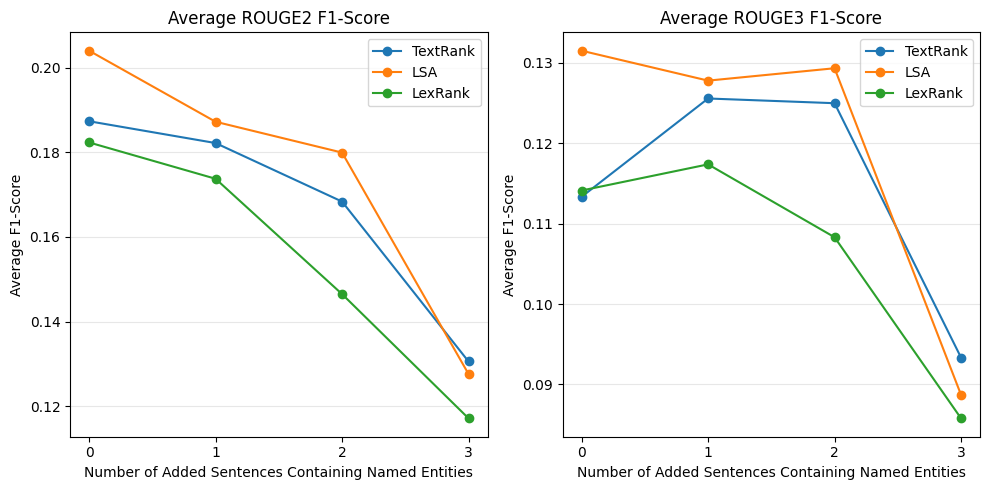

In [6]:
MAX_NEW_SENTENCES = 3


def extract_doc_and_abstraction(data):
    extracted_data = []
    data_idx = -1
    for idx, line in enumerate(data):
        if line == "Document\n":
            data_idx += 1
            extracted_data.append({"document": data[idx + 1].rstrip("\n")})
            continue
        if line.startswith("Facet-"):
            abstraction = line.rstrip("\n").split(" ", 1)[1]
            if "abstractions" not in extracted_data[data_idx]:
                extracted_data[data_idx]["abstractions"] = []
            extracted_data[data_idx]["abstractions"].append(abstraction)
    print(f"Total extracted samples: {len(extracted_data)}")
    return extracted_data


with open("Data/Cnn&Dailymail/low_abstraction.txt", "r", encoding="UTF-8") as f:
    data = extract_doc_and_abstraction(f.readlines())


def rouge_evaluation(reference, hypothesis, rouge_type):
    scorer = rouge_scorer.RougeScorer([rouge_type], use_stemmer=True)
    score = scorer.score(reference, hypothesis)[rouge_type]
    return score


def get_max_rouge_scores(abstractions, summary, rouge_type):
    scores = [rouge_evaluation(abst, str(summary), rouge_type) for abst in abstractions]
    precision = np.max([score.precision for score in scores])
    recall = np.max([score.recall for score in scores])
    fmeasure = np.max([score.fmeasure for score in scores])
    return precision, recall, fmeasure


def add_sents_containing_named_entities(summary, document, max_new_sentences):
    if max_new_sentences == 0:
        return [str(summary)]

    summary_doc = nlp(str(summary))
    summary_entities = {
        ent.text for ent in summary_doc.ents if ent.label_ in ("PERSON", "ORG")
    }

    if not summary_entities:
        return [str(summary)]

    document_sents = Tokenizer(LANGUAGE).to_sentences(document)

    summary_text = str(summary)
    candidates = []

    for sent in document_sents:
        # Skip if it's the summary sentence itself
        if sent == summary_text:
            continue

        sent_doc = nlp(sent)
        sent_entities = {
            ent.text for ent in sent_doc.ents if ent.label_ in ("PERSON", "ORG")
        }

        overlap = summary_entities & sent_entities

        if overlap:
            candidates.append((sent, len(overlap)))

    # Sort by number of matching entities (descending)
    candidates.sort(key=lambda x: x[1], reverse=True)
    if candidates and candidates[0][1] > 2:  # Change threshold to see more/less outputs
        print("Good candidate found:", candidates[0])
        print("Summary text:", summary_text)
        print("Named entities in summary:", summary_entities)

    # Take top max_new_sentences
    selected_sentences = [summary_text]
    selected_sentences.extend(sent for sent, _ in candidates[:max_new_sentences])

    return selected_sentences


textrank_summarizer = TextRankSummarizer(Stemmer(LANGUAGE))
textrank_summarizer.stop_words = get_stop_words(LANGUAGE)
lsa_summarizer = LsaSummarizer(Stemmer(LANGUAGE))
lsa_summarizer.stop_words = get_stop_words(LANGUAGE)
lexrank_summarizer = LexRankSummarizer(Stemmer(LANGUAGE))
lexrank_summarizer.stop_words = get_stop_words(LANGUAGE)

summarizers = ["TextRank", "LSA", "LexRank"]
rouge_types = ["rouge2", "rouge3"]
metrics = ["precision", "recall", "fmeasure"]

TOP_SUMMARIES_COUNT = 5

doc_scores = []
score_template = {
    f"{summarizer}": {
        f"{rouge_type}": {
            metric: [-1 for _ in range(MAX_NEW_SENTENCES + 1)] for metric in metrics
        }
        for rouge_type in rouge_types
    }
    for summarizer in summarizers
}

for doc in data:
    scores = deepcopy(score_template)
    document = doc["document"]
    abstractions = doc["abstractions"]
    parser = PlaintextParser.from_string(document, Tokenizer(LANGUAGE))

    summaries = {f"{summarizer}": [] for summarizer in summarizers}
    summaries["TextRank"] = textrank_summarizer(parser.document, TOP_SUMMARIES_COUNT)[0]
    summaries["LSA"] = lsa_summarizer(parser.document, TOP_SUMMARIES_COUNT)[0]
    summaries["LexRank"] = lexrank_summarizer(parser.document, TOP_SUMMARIES_COUNT)[0]

    summaries["TextRank"] = add_sents_containing_named_entities(
        summaries["TextRank"], document, MAX_NEW_SENTENCES
    )
    summaries["LSA"] = add_sents_containing_named_entities(
        summaries["LSA"], document, MAX_NEW_SENTENCES
    )
    summaries["LexRank"] = add_sents_containing_named_entities(
        summaries["LexRank"], document, MAX_NEW_SENTENCES
    )

    for summarizer in summarizers:
        for rouge_type in rouge_types:
            for i in range(len(summaries[summarizer])):
                precision, recall, fmeasure = get_max_rouge_scores(
                    abstractions, " ".join(summaries[summarizer][: i + 1]), rouge_type
                )
                scores[summarizer][rouge_type]["precision"][i] = precision
                scores[summarizer][rouge_type]["recall"][i] = recall
                scores[summarizer][rouge_type]["fmeasure"][i] = fmeasure

    doc_scores.append(scores)


avg_scores = score_template = {
    f"{summarizer}": {
        f"{rouge_type}": {
            metric: [[] for _ in range(MAX_NEW_SENTENCES + 1)] for metric in metrics
        }
        for rouge_type in rouge_types
    }
    for summarizer in summarizers
}

for doc_score in doc_scores:
    for summarizer in summarizers:
        for rouge_type in rouge_types:
            for metric in metrics:
                for i in range(MAX_NEW_SENTENCES + 1):
                    if doc_score[summarizer][rouge_type][metric][i] >= 0:
                        avg_scores[summarizer][rouge_type][metric][i].append(
                            doc_score[summarizer][rouge_type][metric][i]
                        )

# Take averages
for summarizer in summarizers:
    for rouge_type in rouge_types:
        for metric in metrics:
            for i in range(MAX_NEW_SENTENCES + 1):
                avg_scores[summarizer][rouge_type][metric][i] = np.mean(
                    avg_scores[summarizer][rouge_type][metric][i]
                )


def plot_rouge_scores(ax, rouge_type):
    """Plot average ROUGE scores for the fmeasure metric.
    On x-axis there is the number of added sentences containing named entities.
    On y-axis there is the average ROUGE fmeasure score.
    """
    x = np.arange(0, MAX_NEW_SENTENCES + 1)
    x_ticks = [str(i) for i in range(0, MAX_NEW_SENTENCES + 1)]
    ax.set_xticks(x, x_ticks)
    for summarizer in summarizers:
        y = avg_scores[summarizer][rouge_type]["fmeasure"]
        ax.plot(
            x,
            y,
            marker="o",
            label=summarizer,
        )
    ax.set_title(f"Average {rouge_type.upper()} F1-Score")
    ax.set_xlabel("Number of Added Sentences Containing Named Entities")
    ax.set_ylabel("Average F1-Score")

    ax.legend(loc="upper right", fontsize=10)
    ax.grid(axis="y", alpha=0.3)


# Plot the average ROUGE scores
_, axes = plt.subplots(1, 2, figsize=(10, 5))
for j, rouge_type in enumerate(rouge_types):
    plot_rouge_scores(axes[j], rouge_type)

plt.tight_layout()
plt.show()


### Task 6: Algorithm Performance on Opinosis Dataset


--- Performance of TextRank, Latent Semantic and LexRank algorithms on Opinosis dataset in terms of Rouge-1 and Rouge-2 ---
          ROUGE-1  ROUGE-2
TextRank    0.153    0.036
LSA         0.129    0.022
LexRank     0.238    0.066


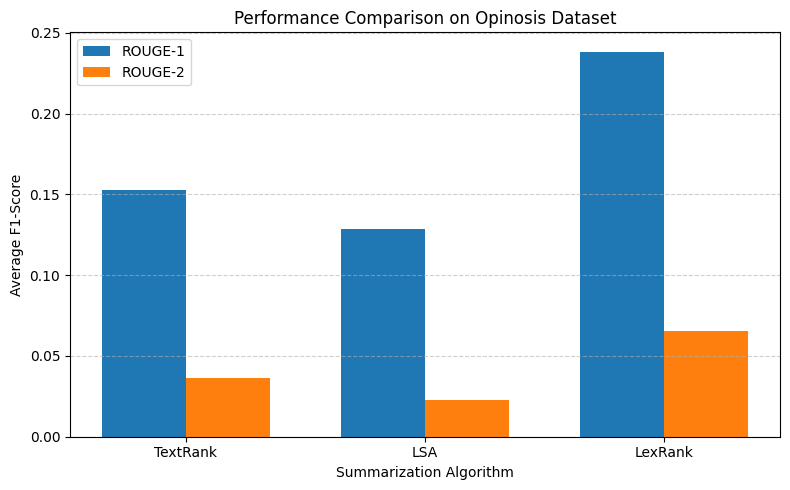

In [7]:
import os
from rouge_score import rouge_scorer
from glob import glob
import pandas as pd


# Helper function for text summarization
def summarize_text(text, summarizer):
    parser = PlaintextParser.from_string(text, Tokenizer(LANGUAGE))
    return " ".join(str(s) for s in summarizer(parser.document, SENTENCES_COUNT))


# Helper function for ROUGE evaluation
def evaluate_rouge(system_summary, reference_summary):
    scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2"], use_stemmer=True)
    scores = scorer.score(reference_summary, system_summary)
    return {k: v.fmeasure for k, v in scores.items()}


# Setup summarizers (use stemming and stopword removal)
summarizers = {
    "TextRank": TextRankSummarizer(Stemmer(LANGUAGE)),
    "LSA": LsaSummarizer(Stemmer(LANGUAGE)),
    "LexRank": LexRankSummarizer(Stemmer(LANGUAGE)),
}
for s in summarizers.values():
    s.stop_words = get_stop_words(LANGUAGE)

# Loop through the opinosis dataset
topics_path = "Data/OpinosisDataset/topics"
summaries_path = "Data/OpinosisDataset/summaries-gold"

result_list = {name: [] for name in summarizers}

for topic_file in os.listdir(topics_path):
    if not topic_file.endswith(".txt.data"):
        continue

    # Get the topic name from the file and construct paths for topics and gold summaries
    topic_name = topic_file.replace("txt.data", "")
    topic_path = os.path.join(topics_path, topic_file)
    summaries_dir = os.path.join(summaries_path, topic_name)

    if not os.path.exists(summaries_dir):
        continue

    # Read all reviews for the topic (there are mixed encodings in the dataset)
    try:
        with open(topic_path, "r", encoding="utf-8") as file:
            text = file.read()
    except UnicodeDecodeError:
        with open(topic_path, "r", encoding="latin-1") as file:
            text = file.read()

    # Read all gold summaries for the topic with glob
    summaries_paths = sorted(glob(os.path.join(summaries_dir, "*.gold")))
    gold_summaries = []
    for s in summaries_paths:
        with open(s, "r", encoding="utf-8") as summary_file:
            gold_summaries.append(summary_file.read())

    # Evaluate each summarizer
    for name, summarizer in summarizers.items():
        system_summary = summarize_text(text, summarizer)
        all_rouge = []
        for gold in gold_summaries:
            all_rouge.append(evaluate_rouge(system_summary, gold))

        # Compute average across all gold summaries
        avg_rouge1 = sum(r["rouge1"] for r in all_rouge) / len(all_rouge)
        avg_rouge2 = sum(r["rouge2"] for r in all_rouge) / len(all_rouge)
        result_list[name].append({"rouge1": avg_rouge1, "rouge2": avg_rouge2})

# Compute overall averages scores into a DataFrame
avg_results = {}
for name, scores in result_list.items():
    avg_r1 = sum(s["rouge1"] for s in scores) / len(scores)
    avg_r2 = sum(s["rouge2"] for s in scores) / len(scores)
    avg_results[name] = {"ROUGE-1": avg_r1, "ROUGE-2": avg_r2}

# Save the variables into a DataFrame where summarizers are as rows
df = pd.DataFrame(avg_results).T
print("--- Performance of TextRank, Latent Semantic and LexRank algorithms on Opinosis dataset in terms of Rouge-1 and Rouge-2 ---")
print(df.round(3))

# Plot side-by-side bar chart
algorithms = df.index
rouge1 = df["ROUGE-1"]
rouge2 = df["ROUGE-2"]

x = np.arange(len(algorithms))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(x - width/2, rouge1, width, label="ROUGE-1")
ax.bar(x + width/2, rouge2, width, label="ROUGE-2")

ax.set_xlabel("Summarization Algorithm")
ax.set_ylabel("Average F1-Score")
ax.set_title("Performance Comparison on Opinosis Dataset")
ax.set_xticks(x)
ax.set_xticklabels(algorithms)
ax.legend()
ax.grid(axis="y", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

### Task 7: Edmundson Summarizer Performance on Opinosis Dataset


In [8]:
def edmundson_summarize():
    # Initialize Edmundson summarizer
    # Has default weights: cue = 1, key = 0, title = 1, location = 1
    summarizer = EdmundsonSummarizer(Stemmer(LANGUAGE))
    summarizer.stop_words = get_stop_words(LANGUAGE)

    # Set null words (irrelevant words)
    summarizer.null_words = get_stop_words(LANGUAGE)

    # Set custom bonus and stigma words
    # For bonus words, include positively relevant words in reviews
    summarizer.bonus_words = {
        "best",
        "excellent",
        "great",
        "good",
        "nice",
        "perfect",
        "better",
        "awesome",
        "recommend",
        "super",
        "fantastic",
        "exceptional",
        "outstanding",
    }
    # For stigma words, include negatively relevant words in reviews
    summarizer.stigma_words = {
        "bad",
        "worst",
        "terrible",
        "poor",
        "horrible",
        "disappointing",
        "avoid",
        "unfortunately",
        "cannot",
        "useless",
        "problem",
        "issue",
        "awful",
    }

    # Initialize ROUGE scorer
    scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2"], use_stemmer=True)
    results = []
    # Process each topic file
    for topic_file in os.listdir(topics_path):
        if not topic_file.endswith(".txt.data"):
            continue
        topic_name = topic_file.replace(".txt.data", "")
        topic_path = os.path.join(topics_path, topic_file)
        summaries_dir = os.path.join(summaries_path, topic_name)
        if not os.path.exists(summaries_dir):
            continue
        # Read all reviews
        try:
            with open(topic_path, "r", encoding="utf-8") as file:
                text = file.read()
        except UnicodeDecodeError:
            with open(topic_path, "r", encoding="latin-1") as file:
                text = file.read()
        # Generate summary
        parser = PlaintextParser.from_string(text, Tokenizer(LANGUAGE))
        summary = " ".join(
            str(sentence) for sentence in summarizer(parser.document, SENTENCES_COUNT)
        )
        # Read and evaluate against gold summaries
        summaries_paths = sorted(glob(os.path.join(summaries_dir, "*.gold")))
        scores_for_topic = []
        for gold_path in summaries_paths:
            with open(gold_path, "r", encoding="utf-8") as f:
                gold_summary = f.read()
                scores = scorer.score(gold_summary, summary)
                scores_for_topic.append(
                    {
                        "rouge1": scores["rouge1"].fmeasure,
                        "rouge2": scores["rouge2"].fmeasure,
                    }
                )
        # Compute average scores
        if scores_for_topic:
            avg_rouge1 = sum(score["rouge1"] for score in scores_for_topic) / len(
                scores_for_topic
            )
            avg_rouge2 = sum(score["rouge2"] for score in scores_for_topic) / len(
                scores_for_topic
            )
            results.append({"rouge1": avg_rouge1, "rouge2": avg_rouge2})
    # Compute and output results
    if results:
        final_rouge1 = sum(result["rouge1"] for result in results) / len(results)
        final_rouge2 = sum(result["rouge2"] for result in results) / len(results)
        print("\nSumy Edmundson summarizer ROUGE-1, ROUGE-2 scores:")
        print(f"ROUGE-1: {final_rouge1:.3f}")
        print(f"ROUGE-2: {final_rouge2:.3f}")
    else:
        print("No results generated")


print("Test the summarizer on Opinosis dataset:")
edmundson_summarize()

Test the summarizer on Opinosis dataset:

Sumy Edmundson summarizer ROUGE-1, ROUGE-2 scores:
ROUGE-1: 0.180
ROUGE-2: 0.041


### Task 8: Performance of Topic-Aware Aprroach for Text Summarization


In [9]:
# Extract topic keywords
def get_topic_keywords(text, structure=None, topic_name=None):
    if topic_name:
        return [word.lower() for word in topic_name.split()]
    elif structure == "opinosis":
        name = text.replace(".txt", "").replace(".data", "")
        return [word.lower() for word in name.replace("_", " ").split()]
    else:
        # General case, extract 3 text keywords
        freq = {}
        for token in nlp(text):
            if token.is_alpha and not token.is_stop:
                key = token.text.lower()
                freq[key] = freq.get(key, 0) + 1
        if not freq:
            return []
        sorted_items = sorted(freq.items(), key=lambda x: x[1], reverse=True)[:3]
        return [k for k, _ in sorted_items]


# Return tf-idf topic relevance scoring
def get_topic_relevance(sentences, topic_keywords):
    if not sentences or not topic_keywords:
        return np.zeros(len(sentences))
    corpus = sentences + [" ".join(topic_keywords)]
    vectorizer = TfidfVectorizer(stop_words="english")
    tfidf = vectorizer.fit_transform(corpus)
    topic_vector = tfidf[-1]
    sentence_vectors = tfidf[:-1]
    relevance = cosine_similarity(sentence_vectors, topic_vector).flatten()
    # Normalize to [0,1]
    if relevance.max() > 0:
        relevance = (relevance - relevance.min()) / (relevance.max() - relevance.min())
    return relevance


# Summarize to account for topic of document
def summarize_for_topic(text, summarizer, topic_keywords=None):
    if topic_keywords is None:
        topic_keywords = get_topic_keywords(text)
    parser = PlaintextParser.from_string(text, Tokenizer(LANGUAGE))
    # Get more summarizer's top sentences (3*3) to include for calculation
    base_count = SENTENCES_COUNT * 3
    summary_candidates = summarizer(parser.document, base_count)
    sentences = [str(sent) for sent in summary_candidates]
    # Get relevance to topic for selected sentences
    topic_relevance = get_topic_relevance(sentences, topic_keywords)
    # Calculate final scores for summarizer's scores times relevance
    base_scores = np.linspace(1, 0, len(sentences))
    final_scores = base_scores * topic_relevance
    # Return selected sentences
    top_indices = np.argsort(-final_scores)[:SENTENCES_COUNT]
    selected = [sentences[i] for i in sorted(top_indices)]
    return " ".join(selected)


def evaluate_opinosis():
    results = {name: [] for name in summarizers}
    for topic_file in os.listdir(topics_path):
        if not topic_file.endswith(".txt.data"):
            continue
        topic_keywords = get_topic_keywords(topic_file, structure="opinosis")
        topic_path = os.path.join(topics_path, topic_file)
        summaries_dir = os.path.join(
            summaries_path, topic_file.replace(".txt.data", "")
        )
        if not os.path.exists(summaries_dir):
            continue
        try:
            with open(topic_path, "r", encoding="utf-8") as f:
                text = f.read()
        except UnicodeDecodeError:
            with open(topic_path, "r", encoding="latin-1") as f:
                text = f.read()
        gold_paths = sorted(glob(os.path.join(summaries_dir, "*.gold")))
        golds = [open(p, "r", encoding="utf-8").read() for p in gold_paths]
        for name, summarizer in summarizers.items():
            summary = summarize_for_topic(text, summarizer, topic_keywords)
            scores = [evaluate_rouge(summary, gold) for gold in golds]
            avg_scores = {
                metric: np.mean([s[metric] for s in scores])
                for metric in ["rouge1", "rouge2"]
            }
            results[name].append(avg_scores)
    return results


def evaluate_cnn():
    results = {name: [] for name in summarizers}
    with open("Data/Cnn&Dailymail/low_abstraction.txt", "r", encoding="utf-8") as f:
        for line in f:
            if line.startswith("Document\n"):
                doc = next(f).strip()
                abstracts = []
                while True:
                    abstract_line = next(f, None)
                    if not abstract_line or abstract_line == "Document\n":
                        break
                    if abstract_line.startswith("Facet-"):
                        abstracts.append(abstract_line.split(" ", 1)[1].strip())
                if abstracts:
                    for name, summarizer in summarizers.items():
                        summary = summarize_for_topic(doc, summarizer)
                        scores = [evaluate_rouge(summary, ab) for ab in abstracts]
                        avg_scores = {
                            metric: np.mean([s[metric] for s in scores])
                            for metric in ["rouge1", "rouge2"]
                        }
                        results[name].append(avg_scores)
    return results


# Initialize summarizers
summarizers = {
    "TextRank": TextRankSummarizer(Stemmer(LANGUAGE)),
    "LSA": LsaSummarizer(Stemmer(LANGUAGE)),
    "LexRank": LexRankSummarizer(Stemmer(LANGUAGE)),
}
for s in summarizers.values():
    s.stop_words = get_stop_words(LANGUAGE)


# Evaluate on both datasets
print("\nTesting summarizaton to account for topic of document on Opinosis dataset:")
opinosis_results = evaluate_opinosis()
for name, scores in opinosis_results.items():
    avg_r1 = np.mean([s["rouge1"] for s in scores])
    avg_r2 = np.mean([s["rouge2"] for s in scores])
    print(f"{name}: ROUGE-1: {avg_r1:.3f}, ROUGE-2: {avg_r2:.3f}")

print("\nTesting summarization to account for topic of document CNN/dailymail dataset:")
cnn_results = evaluate_cnn()
for name, scores in cnn_results.items():
    avg_r1 = np.mean([s["rouge1"] for s in scores])
    avg_r2 = np.mean([s["rouge2"] for s in scores])
    print(f"{name}: ROUGE-1: {avg_r1:.3f}, ROUGE-2: {avg_r2:.3f}")


Testing summarizaton to account for topic of document on Opinosis dataset:
TextRank: ROUGE-1: 0.172, ROUGE-2: 0.044
LSA: ROUGE-1: 0.142, ROUGE-2: 0.026
LexRank: ROUGE-1: 0.230, ROUGE-2: 0.058

Testing summarization to account for topic of document CNN/dailymail dataset:
TextRank: ROUGE-1: 0.174, ROUGE-2: 0.075
LSA: ROUGE-1: 0.158, ROUGE-2: 0.060
LexRank: ROUGE-1: 0.178, ROUGE-2: 0.070


### Task 10: Full Text Summarization GUI


In [10]:
# The summarizer GUI will open in a new window and this cell will run as long as the window is open.
# Helper function for text summarization
def summarize_text(source, is_url=False):
    try:
        if is_url:
            parser = HtmlParser.from_url(source, Tokenizer(LANGUAGE))
            text = " ".join(str(sent) for sent in parser.document.sentences)
            opinosis_file = False
        else:
            # Check for if the file is Opinosis topic file
            opinosis_file = (
                isinstance(source, str)
                and source.endswith(".txt.data")
                and os.path.exists(source)
            )
            # Get text from the source file, expect mixed encodings
            try:
                parser = PlaintextParser.from_file(source, Tokenizer(LANGUAGE))
                text = " ".join(str(sent) for sent in parser.document.sentences)
            except Exception:
                encodings = ("utf-8", "latin-1")
                content = None
                for encoding in encodings:
                    try:
                        with open(source, "r", encoding=encoding) as f:
                            content = f.read()
                        break
                    except Exception:
                        continue
                if content is None:
                    raise
                parser = PlaintextParser.from_string(content, Tokenizer(LANGUAGE))
                text = " ".join(str(sent) for sent in parser.document.sentences)

        # Initialize summarizers
        textrank = TextRankSummarizer(Stemmer(LANGUAGE))
        textrank.stop_words = get_stop_words(LANGUAGE)
        lsa = LsaSummarizer(Stemmer(LANGUAGE))
        lsa.stop_words = get_stop_words(LANGUAGE)
        lexrank = LexRankSummarizer(Stemmer(LANGUAGE))
        lexrank.stop_words = get_stop_words(LANGUAGE)
        edmundson = EdmundsonSummarizer(Stemmer(LANGUAGE))
        edmundson.stop_words = get_stop_words(LANGUAGE)
        edmundson.null_words = get_stop_words(LANGUAGE)
        edmundson.bonus_words = {
            "best",
            "excellent",
            "great",
            "good",
            "nice",
            "perfect",
            "better",
            "awesome",
            "recommend",
            "super",
            "fantastic",
            "exceptional",
            "outstanding",
        }
        edmundson.stigma_words = {
            "bad",
            "worst",
            "terrible",
            "poor",
            "horrible",
            "disappointing",
            "avoid",
            "unfortunately",
            "cannot",
            "useless",
            "problem",
            "issue",
            "awful",
        }

        # Create summaries dictionary with the summarizer objects
        summarizers = {
            "TextRank": textrank,
            "LSA": lsa,
            "LexRank": lexrank,
            "Edmundson": edmundson,
        }

        account_topic = topic_var.get()
        named_entity = entity_var.get()
        summaries = {}

        for name, summarizer in summarizers.items():
            # Account for topic summarization
            if account_topic:
                # Extract keywords from filename if Opinosis topic file
                if not is_url and opinosis_file:
                    filename = os.path.basename(source)
                    kw = get_topic_keywords(filename, structure="opinosis")
                else:
                    # Check if topic name is given
                    topic_name = entry_topic.get().strip()
                    if topic_name:
                        kw = get_topic_keywords(text, topic_name=topic_name)
                    else:
                        kw = get_topic_keywords(text)
                summaries[name] = summarize_for_topic(
                    text, summarizer, topic_keywords=kw
                )
            else:
                # Base summarization
                base_summary = " ".join(
                    str(s) for s in summarizer(parser.document, SENTENCES_COUNT)
                )
                if named_entity:
                    summaries[name] = add_sents_containing_named_entities(
                        base_summary, text, MAX_NEW_SENTENCES
                    )
                else:
                    summaries[name] = base_summary

        return summaries

    except Exception as e:
        messagebox.showerror("Error", str(e))
        return None


# Helper function for browsing a file
def browse_file():
    filename = filedialog.askopenfilename(
        filetypes=[("Text files", "*.txt *.txt.data")]
    )
    entry_source.delete(0, tk.END)
    entry_source.insert(0, filename)


# Helper function for running summary
def run_summary():
    source = entry_source.get().strip()
    if not source:
        messagebox.showwarning("Input Error", "Please enter a URL or choose a file")
        return None

    is_url = source.startswith("http")
    summaries = summarize_text(source, is_url)

    if summaries:
        # Clear existing summaries
        text_textrank.delete(1.0, tk.END)
        text_lsa.delete(1.0, tk.END)
        text_lexrank.delete(1.0, tk.END)
        text_edmundson.delete(1.0, tk.END)

        # Insert new summaries
        text_textrank.insert(tk.END, summaries["TextRank"])
        text_lsa.insert(tk.END, summaries["LSA"])
        text_lexrank.insert(tk.END, summaries["LexRank"])
        text_edmundson.insert(tk.END, summaries["Edmundson"])


# GUI setup using tkinter library
root = tk.Tk()
root.title("Text Summarizer")
root.geometry("1200x800")

# Top frame for input
frame_top = tk.Frame(root)
frame_top.pack(pady=10)

tk.Label(
    frame_top, text="Enter URL or choose a file to get 3 most important sentences:"
).pack(anchor="w", padx=5)
entry_source = tk.Entry(frame_top, width=70)
entry_source.pack(side=tk.LEFT, padx=5)

btn_browse = tk.Button(frame_top, text="Browse File", command=browse_file)
btn_browse.pack(side=tk.LEFT, padx=5)

btn_summarize = tk.Button(frame_top, text="Summarize", command=run_summary)
btn_summarize.pack(side=tk.LEFT, padx=5)

# Options frame to include additional methodologies in GUI
frame_opts = tk.Frame(root)
frame_opts.pack(pady=5)

topic_var = tk.BooleanVar()
entity_var = tk.BooleanVar()
tk.Checkbutton(
    frame_opts, text="Account for topic of document", variable=topic_var
).pack(side=tk.LEFT)
tk.Checkbutton(
    frame_opts, text="Extend summarization with named-entities", variable=entity_var
).pack(side=tk.LEFT)
tk.Label(frame_opts, text="(Optional) write topic name:").pack(side=tk.LEFT, padx=5)
entry_topic = tk.Entry(frame_opts, width=30)
entry_topic.pack(side=tk.LEFT)

# Frame for output text areas
frame_texts = tk.Frame(root)
frame_texts.pack(fill=tk.BOTH, expand=True)

# TextRank output
frame_textrank = tk.Frame(frame_texts)
frame_textrank.pack(side=tk.LEFT, fill=tk.BOTH, expand=True, padx=5)
tk.Label(frame_textrank, text="TextRank Summary:").pack(anchor="n", pady=5)
text_textrank = scrolledtext.ScrolledText(frame_textrank, wrap=tk.WORD, width=30)
text_textrank.pack(fill=tk.BOTH, expand=True)

# LSA output
frame_lsa = tk.Frame(frame_texts)
frame_lsa.pack(side=tk.LEFT, fill=tk.BOTH, expand=True, padx=5)
tk.Label(frame_lsa, text="LSA Summary:").pack(anchor="n", pady=5)
text_lsa = scrolledtext.ScrolledText(frame_lsa, wrap=tk.WORD, width=30)
text_lsa.pack(fill=tk.BOTH, expand=True)

# LexRank output
frame_lexrank = tk.Frame(frame_texts)
frame_lexrank.pack(side=tk.LEFT, fill=tk.BOTH, expand=True, padx=5)
tk.Label(frame_lexrank, text="LexRank Summary:").pack(anchor="n", pady=5)
text_lexrank = scrolledtext.ScrolledText(frame_lexrank, wrap=tk.WORD, width=30)
text_lexrank.pack(fill=tk.BOTH, expand=True)

# Edmundson output
frame_edmundson = tk.Frame(frame_texts)
frame_edmundson.pack(side=tk.LEFT, fill=tk.BOTH, expand=True, padx=5)
tk.Label(frame_edmundson, text="Edmundson Summary:").pack(anchor="n", pady=5)
text_edmundson = scrolledtext.ScrolledText(frame_edmundson, wrap=tk.WORD, width=30)
text_edmundson.pack(fill=tk.BOTH, expand=True)

print("Text Summarizer GUI is running in a separate window!")
root.mainloop()

Text Summarizer GUI is running in a separate window!
